# Imports

In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import inspect  # inspect.signature()
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.signal import firwin, freqz

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [4]:
dataset_name = constants.MASS_KC_NAME
fs = 200
task_mode = constants.N2_RECORD
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


In [7]:
# Segment
subject_id = 2
signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
annots = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=task_mode)
print("%d annotations" % len(annots))

633 annotations


In [93]:
def lowpass(time, signal, fs, cutoff, numtaps):
    lp_fir = firwin(numtaps, cutoff=cutoff, window="hamming", fs=fs)
    samples_removed = numtaps // 2
    signal_padded = np.concatenate([np.zeros(samples_removed), signal, np.zeros(samples_removed)])
    new_signal = np.convolve(signal_padded, lp_fir, mode="valid")
    new_time = time
    # compute frequency response of filter
    w, h = freqz(lp_fir)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    return new_time, new_signal, lp_fir, resp_freq, resp_amp

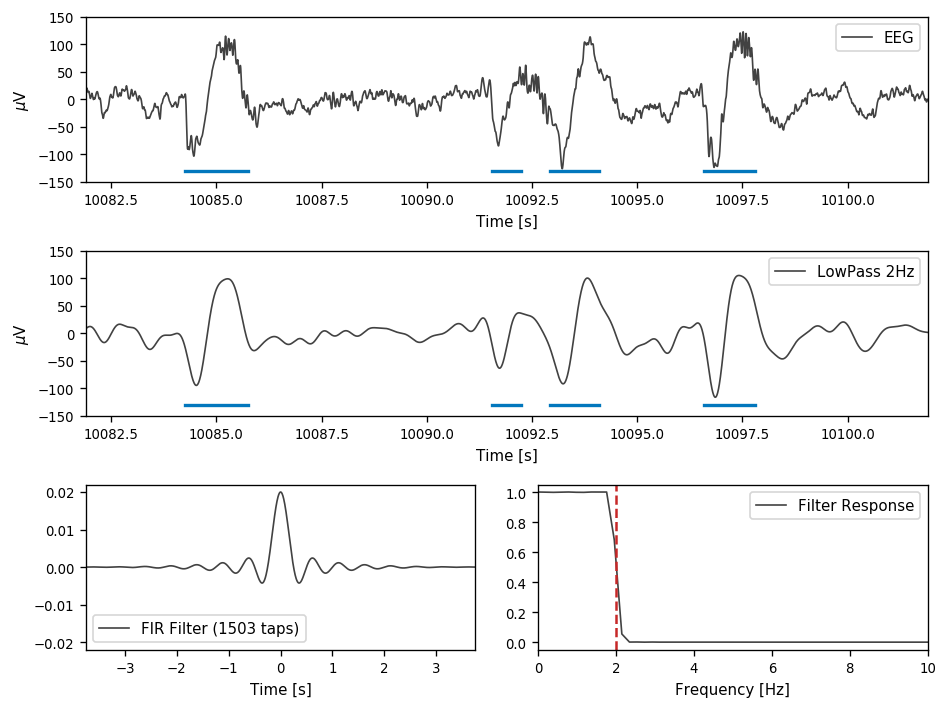

In [99]:
annot_idx = 198  # 100
window = 20
cutoff = 2

central_sample = annots[annot_idx, :].mean()
start_sample= int(central_sample - window * fs / 2)
end_sample = int(start_sample + window * fs)
segment_signal = signal[start_sample:end_sample]
segment_annots = utils.filter_stamps(annots, start_sample, end_sample)
time_axis = np.arange(start_sample, end_sample) / fs

fig = plt.figure(figsize=(8, 6), dpi=120)
gs = fig.add_gridspec(3, 2)

# Signal with stamp
ax = fig.add_subplot(gs[0, :])
ax.plot(time_axis, segment_signal, linewidth=1, color=viz.GREY_COLORS[8], label='EEG')
for kc in segment_annots:
    ax.plot(kc / fs, [-130, -130], color=viz.PALETTE['blue'], linewidth=2)
ax.set_ylabel('$\mu$V', fontsize=9)
ax.set_xlabel('Time [s]', fontsize=9)
ax.set_ylim([-150, 150])
ax.set_xlim([start_sample/fs, end_sample/fs])
ax.tick_params(labelsize=8)
ax.legend(fontsize=9)

ref_cutoff = 6
ref_numtaps = 501
numtaps = 2 * int((ref_cutoff / cutoff) * ref_numtaps // 2) + 1
new_time, new_signal, lp_fir, resp_freq, resp_amp = lowpass(time_axis, segment_signal, fs, cutoff, numtaps)
filter_time_axis = (np.arange(numtaps) - numtaps//2) / fs

# Filtered signal
ax = fig.add_subplot(gs[1, :])
ax.plot(new_time, new_signal, linewidth=1, color=viz.GREY_COLORS[8], label='LowPass %sHz' % cutoff)
for kc in segment_annots:
    ax.plot(kc / fs, [-130, -130], color=viz.PALETTE['blue'], linewidth=2)
ax.set_ylabel('$\mu$V', fontsize=9)
ax.set_xlabel('Time [s]', fontsize=9)
ax.set_ylim([-150, 150])
ax.set_xlim([start_sample/fs, end_sample/fs])
ax.tick_params(labelsize=8)
ax.legend(fontsize=9)

# Filter
ax = fig.add_subplot(gs[2, 0])
ax.plot(
    filter_time_axis, lp_fir, linewidth=1, color=viz.GREY_COLORS[8], label='FIR Filter (%d taps)' % numtaps)
ax.tick_params(labelsize=8)
max_x = np.max(np.abs(filter_time_axis))
max_y = np.max(np.abs(lp_fir))
ax.set_xlim([-max_x, max_x])
ax.set_ylim([-1.1*max_y, 1.1*max_y])
ax.legend(fontsize=9)
ax.set_xlabel('Time [s]', fontsize=9)

# Filter frequency response
ax = fig.add_subplot(gs[2, 1])
ax.plot(resp_freq, resp_amp, linewidth=1, color=viz.GREY_COLORS[8], label='Filter Response')
ax.axvline(cutoff, color=viz.PALETTE['red'], linewidth=1.5, linestyle="--")
ax.set_xlim([0, 10])
ax.tick_params(labelsize=8)
ax.legend(fontsize=9)
ax.set_xlabel('Frequency [Hz]', fontsize=9)
    
plt.tight_layout()
plt.show()